<a href="https://colab.research.google.com/github/shriver42/ESAA/blob/%ED%95%84%EC%82%AC-%EA%B3%BC%EC%A0%9C/0329_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[01]평가
 - 머신러닝 : 데이터 가공/변환, 모델 학습/예측, 평가의 프로세스로 구성된다
 - 성능 평가 지표: 모델이 회귀 or 분류 에 따라 달라진다
  - 회귀 : 실제값과 예측값의 오차 평균에 기반
  - 분류 : 회귀보다 추가적인 방법 필요
 - 분류의 성능 평가 지표:</br> 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC
 - 분류의 종류 : </br> 이진 분류, 멀티 분류

[01-1] 정확도(Accuravy)
 - 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
 - 정확도 수치 하나만으로 보면 ML 모델 성능 왜곡 가능

In [48]:
#Classifier 만들어 주기
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit(self,X,y=None):
    pass
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else :
        pred[i] = 1

    return pred

In [49]:
#타이타닉 생존자 수 예측 수행하기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


#이전에 한 데이터 전처리 과정

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

#전처리 함수 가져오기 위한 코드
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

#원본 데이터를 재로딩, 데이터 가공, 학습 데잍터/테스트 데이터 분할
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train,X_test,y_train,y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2,random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/ 예측/ 평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifie의 정확도는 : {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifie의 정확도는 : 0.7877


- 불균형한 데이터에서 정확도의 위험성
 - 결과 : 모든 것을 0으로 예측해도 9정확도가 90%로 나오게 된다

In [50]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self,X,y):
    pass

  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self,X):
    return np.zeros((len(X),1), dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digiti()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False 이고 0으로 변환
y = (digits.target==7).astype(int)
X_train,X_test,y_train,y_test = train_test_split(digits.data, y, random_state = 11)

In [51]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스터 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:(:.3f)'.format(accuracy_score(y_test,fakepred)))

레이블 테스터 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:(:.3f)


[01-2] 오차 행렬(Confusion Matrix, 혼동행렬)
 - 이진 분류 예측 오류 + 어떤 유형의 예측 오류가 발생하는 지 함께 보여준다
 - TN/FP/FN/TP : 4가지 유형이 있다</br> 실제 클래스가 앞의 글자이며, 예측값이 뒤의 글자이다.
  - TN : 예측값을 Negative 값 0 으로 예측, 실제 값 또한 Negative 0
  - FP : 예측값을 Positive 값 1으로 예측, 실제 값은 Negative 0
  - FN : 예측값을 Negative 값 0으로 예측, 실제 값은 Positive 1
  - TP : 예측값을 Positive 값 1으로 예측, 실제 갑 또한 Positive 1
 - 데이터 중에서 중점적으로 찾아야 하는 매우 적은 결괏값에 Positive를 설정해 1 부여
 - 이로 부터, 정확도, 정밀도, 재현율의 값들을 알 수 있다
 - 정확도 = (TN+TP)/(TN+FP+FN+TP)

In [52]:
#오차 행렬을 구하는 API : confusion_matrix()
from sklearn.metrics import confusion_matrix

#ndarray 형태로 출력된다
confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]])

[01-3] 정밀도와 재현율
 - Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다
 - 정밀도 = TP/(FP+TP)
 - 재현율 = TP/(FN+TP)
  - 민감도, TPR 이라고도 불린다
 - 정밀도와 재현율은 분류 모델의 업무 특성에 따라 더 중요한 지표로 간주되는 게 달라진다
  - 실제 Positive 양성 데이터를 Negative로 판단하면 업무상 큰 영향이 발생하는 경우 -> 재현율 중요</br>Ex) 암환자 진단, 금융 사기 적발 모델
  - 실제 Negative 음성인 데이터를 Positive 예측으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우 -> 정밀도 중요</br>EX) 스팸 메일 여부 판단 모델
 - 특정 지표가 강조돼야 할 경우, 결정 임곗값을 조정해 정밀도 또는 재현율의 수치를 높인다 : 트레이드오프
  - 개별 레이블별로 결정 확률을 구한 후 예측 확률이 큰 레이블 값으로 예측하게 된다
  - 이진 분류에서는, 임곗값을 0.5로 정하고 이 기준보다 크면 Positive, 작으면 Negative로 결정한다

In [53]:
#정밀도 계산을 위한 precision_score()
#재현율 계산을 위한 recall_score()
#평가 간편하게 적용을 위한 confusion matrix, accuracy, percision,recall -> get_clf_eval() 한번에 호출

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도: {1:.4f}, 재현율:{2:.4f}'.format(accuracy,precision,recall))

In [54]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측하기

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테슽트 데이터 분할
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df,y_titanic_df,test_size = 0.2, random_state = 11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도: 0.7742, 재현율:0.7869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 개별 예측 확률을 반환한다 : predict_proba()
 - 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하다
 - ndarray(mxn) 형태로 반환한다 -> m : 입력 데이트 레코드의 수, n: 클래스 값 유형
 -각 열은 개별 클래스의 예측 확률. 첫번째: 0(Negative) , 두번째: 1(Positive)

In [55]:
#predict_proba()와 predict() 결과 비교해보기
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n :', pred_proba[:3])

#예측확률 array와 예측 결괏값 array를 병합(concatente)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 : [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


- 트레이드 방식 이해하기 : Binarizer 클래스 이용

In [56]:
from sklearn.preprocessing import Binarizer
x = [[1,-1,-2],
     [2,0,0],
     [0,1.1,1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(x))

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [57]:
#Binarizer을 이용해 사이킷런의 의사(pesudo) 만들기 -> predict()가 predict_proba()에 기반한다는 사실을 알 수 있음
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임계값임.
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도: 0.7742, 재현율:0.7869


In [58]:
#임곗값 낮춘 후 평가 지표 변화 보기
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)       #재현율이 올라가고 정밀도가 떨어졌다

오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도: 0.7183, 재현율:0.8361


In [59]:
#테스트를 수행할 모든 임겠값 리스트 객체로 저장.
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,threshold):
  #thresholds list객체 내의 값을 차례로 iteration하면서 Evlauation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:',custom_threshold)
    get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도: 0.7183, 재현율:0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도: 0.7656, 재현율:0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도: 0.7742, 재현율:0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도: 0.8364, 재현율:0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도: 0.8824, 재현율:0.7377


- precision_recall_curve()
 - 입력 파라미터 : y_true(실제 클래스값 배열), probas_pred(positive 칼럼 예측 확률 배열)
 - 반환 값 : 정밀도, 재현율

In [60]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도: [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


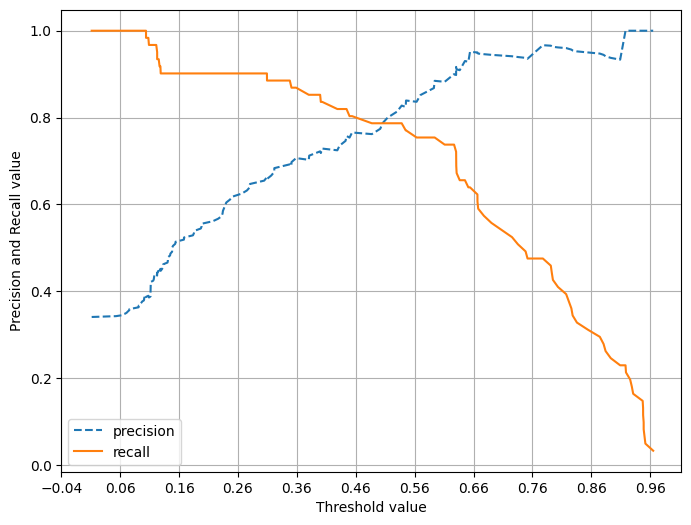

In [61]:
#시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  prrecision, recalls,thresholds = precision_recall_curve(y_test,pred_proba_c1)

  #x축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds,precisions[0:threshold_boundary], linestyle='--',label='precision')
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

  #threshold 값 x 축의 scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  #x축,y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend();plt.grid()
  plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

- 정밀도와 재현율의 맹점
 - 정밀도가 100%가 되는 방법 : 확실한 경우에만 Positive로 예측하고 나머지 경우에는 모두 Negative로 예측
 - 재현율이 100%가 되는 방법 : 모든 환자를 Positive로 예측
 - 두 개의 수치는 상호 보완할 수 있는 수준에서 적용되어야 한다

[01-4]  F1 스코어 : f1_score()
- 정밀도와 재현율의 결합한 지표</br>
F1 = 2 * (precision*recall)/(precision+recall)

In [62]:
#로지스틱 회귀 기반 타이타닉 생존자 모델의 F1 스코어 구하기
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [63]:
#타이타닉 생존자 예측에서 F1 스코어를 포함한 평가 지표
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  #F1 스코어 추가
  f1 = f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1: {3:.4f}'.format(accuracy, precision,recall,f1))

thresholds = [0.4,0.45,0.50,0.55,0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율 : 0.8361, F1: 0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율 : 0.8033, F1: 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율 : 0.7869, F1: 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율 : 0.7541, F1: 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율 : 0.7377, F1: 0.8036


[01-5] ROC 곡선과 AUC
- ROC 곡선 : FPR이 변할 때 TPR이 어떻게 변하는지 나타내는 곡선
 - TPR은 재현율(=민감도)를 나타낸다. 이는 실제값 Positive가 정확히 예측돼야 하는 수준을 나타낸다.
 - 이에 대응하는 지표로 TNR인 특이성이 있다. 이는 실제값 Negative가 정확히 예측돼야 하는 수준을 나타낸다.</br>
 TNR = TN / (FP+TN)
 -x축을 나타내는 FPR은 1-TNR로 나타낼 수 있다.</br>
  FPR = FP / (FP+TN) = 1-TNR = 1-민감도
 - 그래프의 대각선에서 멀어질 수록 성능이 뛰어난 것이다.
- AUC 면적 : ROC곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋다

In [64]:
#roc_curve를 이용해 타이나닉 생존자 예측 모델의 FPR,TPR, 임곘값 구하기
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs,tprs,thresholds = roc_curve(y_test,pred_proba_class1)
#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)

print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값:',np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR,TPR 값
print('샘플 임곗값별 FPR: ',np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


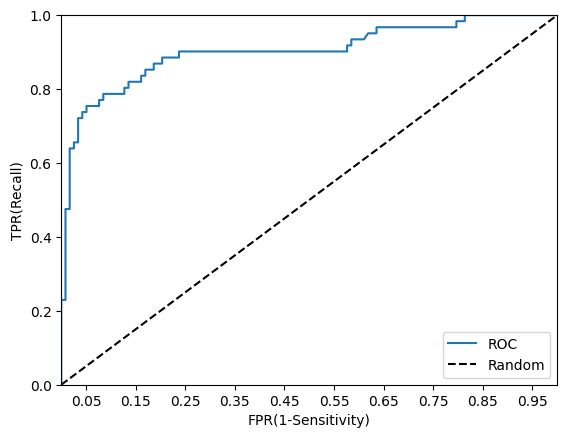

In [65]:
def roc_curve_plot(y_test,pred_proba_c1):
  #임곗값에 따른 FPR,TPR 값을 반환받음.
  fprs,tprs,thresholds = roc_curve(y_test,pred_proba_c1)
  #ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs,tprs,label='ROC')
  #가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1],'k--',label='Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X, Y 축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test,pred_proba[:,1])

In [66]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8341


In [67]:
#타이타닉 생존자 예측 모델에 ROC,AUC 까지 추가
def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 = f1_score(y_test,pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision,recall,f1,roc_auc))